In [20]:
import sys, os, importlib, shutil
import requests
import rasterio, elevation, richdem
import rasterio.warp

import pandas as pd
import geopandas as gpd
import numpy as np

from rasterio import features
from matplotlib import pyplot
from shapely.geometry import MultiPolygon, Polygon

#Import GOST urban functions
sys.path.append("../")
import src.UrbanRaster as urban
import src.urban_helper as helper

#Import raster helpers
sys.path.append("../../gostrocks/src")

import GOSTRocks.rasterMisc as rMisc
from GOSTRocks.misc import tPrint

In [160]:
global_bounds_adm1 = "/home/public/Data/GLOBAL/ADMIN/Admin1_Polys.shp"
iso3 = 'GHA'
output_folder = "/home/wb411133/temp/%s_URBAN_DATA" % iso3
pop_layer = os.path.join(output_folder, "FINAL_STANDARD", "%s_GHS.tif" % iso3)
temp_pop_file = os.path.join(output_folder, "GHS_TEMP.tif")
deg_file = os.path.join(output_folder, "FINAL_STANDARD", "GHS_DEG.tif")
adm1_file = os.path.join(output_folder, "ADM1.shp")

In [3]:
inG1 = gpd.read_file(global_bounds_adm1)
inD1 = inG1.loc[inG1['ISO3'] == iso3]
inD1 = inD1.to_crs({'init':'epsg:4326'})
if not os.path.exists(adm1_file):
    inD1.to_file(adm1_file)

if not os.path.exists(temp_pop_file):
    inR = rasterio.open(pop_layer)
    selD = inD1.loc[inD1['WB_ADM1_NA'] == "Central"]
    rMisc.clipRaster(inR, selD, temp_pop_file)

In [162]:
importlib.reload(urban)
xx = urban.urbanGriddedPop(temp_pop_file)  #(pop_layer)
res = xx.calculateDegurba(urbDens=21, hdDens=(15 * 7), minPopThresh=0.5 * 7, out_raster=deg_file, verbose=True)

16:28:55	: extracting urban clusters
16:28:55	: Creating Shape 0
16:28:58	: Creating Shape 1000
16:28:58	: extracting hd clusters
16:29:02	: Creating Shape 2000
16:29:05	: Creating Shape 3000
16:29:05	: performing distance calculations


In [152]:
features = res['shapes']
sel = pd.DataFrame(features, columns=['ID','POP','CLASS','geometry'])
sel = gpd.GeoDataFrame(sel, geometry="geometry", crs=xx.inR.crs)
to_be    = sel.loc[sel['CLASS'] == 21]
to_be    = to_be.loc[to_be['POP'] < hdThresh]        
distance = sel.loc[sel['CLASS'].isin([21,23])]
dist_shp = distance.sindex        


In [153]:

def calc_nearest(x, dist_gpd, dist_idx):
    xx = dist_gpd.iloc[list(dist_idx.nearest([x.centroid.x, x.centroid.y], 2))]
    dists = xx['geometry'].apply(lambda y: y.distance(x))
    try:
        return(min(dists[dists > 0]))
    except:
        return(0)

    return(max(dists))

to_be['dist'] = to_be['geometry'].apply(lambda x: calc_nearest(x, distance, dist_shp))

In [154]:
features_22 = to_be.loc[to_be['dist'] > 3000]


In [156]:
cShape = features_22.unary_union.__geo_interface__
data = xx.inR.read()
final_raster
mask = rasterize([(cShape, 0)], out_shape=data[0,:,:].shape,fill=1,transform=xx.inR.transform)
        

17

# Plotting

In [48]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

In [54]:
ax.imshow?

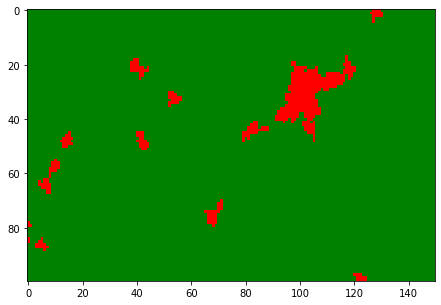

In [63]:
cmap = ListedColormap(["lightgreen", "green", "darkgreen", "yellow", 'brown', 'black', 'red'])
norm = colors.BoundaryNorm([10, 11, 12, 13, 21, 22, 23, 30], 7)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(hd[350:450,500:650], cmap=cmap, norm=norm)
plt.show()

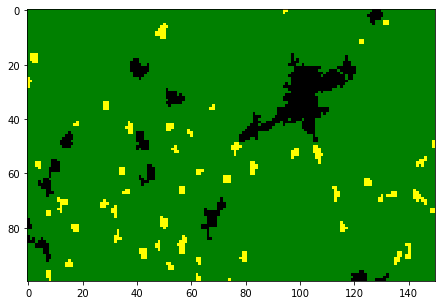

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(urb[350:450,500:650], cmap=cmap, norm=norm)#, extent=[350, 450, 650, 500])
plt.show()

In [62]:
ax.imshow?

# DEBUGGING

In [4]:
import geojson, json

from shapely.geometry import shape, Polygon
from rasterio import features
from rasterio.features import rasterize

urbDens=3 * 7
hdDens=15 * 7
urbThresh=5000
hdThresh=50000
minPopThresh=0.5 * 7
out_raster = deg_file
print_message=''
verbose=False

In [36]:
xx = urban.urbanGriddedPop(temp_pop_file)
popRaster = xx.inR
data = popRaster.read()
urban_raster = data * 0
final_raster = data[0,:,:] * 0 + 11

urban_raster[np.where(data > hdDens)] = 30

idx = 0
allFeatures = []
#Analyze the high density shapes
for cShape, value in features.shapes(urban_raster, transform=popRaster.transform):
    if idx % 1000 == 0 and verbose:
        tPrint("%s: Creating Shape %s" % (print_message, idx))
    idx = idx + 1
    if value > 0:
        if value == 30: # only smooth the HD density shapes
            origShape = cShape
            xx = shape(cShape)
            xx = Polygon(xx.exterior)
            cShape = xx.__geo_interface__
        #If the shape is urban, claculate total pop        
        mask = rasterize([(cShape, 0)], out_shape=data[0,:,:].shape,fill=1,transform=popRaster.transform)
        inData = np.ma.array(data=data, mask=mask.astype(bool))
        pop = np.nansum(inData) 

        val = 0
        if pop > 5000:
            ### TODO - if the totalpop is < 50k, may need to unsmooth the shape
            val = 23
        if pop > 50000:
            val = 30

        #Burn value into the final raster
        mask = (mask^1) * val        
        yy = np.dstack([final_raster, mask])
        final_raster = np.amax(yy, axis=2)
        allFeatures.append([idx, pop, val, shape(geojson.loads(json.dumps(cShape)))])
HD_raster = final_raster

In [39]:
unique_elements, counts_elements = np.unique(HD_raster, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))


[[1.10000e+01 2.30000e+01 3.00000e+01]
 [4.50917e+05 1.62100e+03 2.32200e+03]]


In [ ]:
final_raster = data[0,:,:] * 0
yy = np.dstack([final_raster, mask])
final_raster = np.amax(yy, axis=2)        

In [ ]:
mask = rasterize([(cShape, 0)], out_shape=data[0,:,:].shape,fill=1,transform=popRaster.transform)

In [17]:
tempR = rasterio.open(temp_pop_file)
tempR.shape

(630, 722)

In [18]:
tempR.meta


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -200.0,
 'width': 722,
 'height': 630,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
 'transform': Affine(250.0, 0.0, -220500.0,
        0.0, -250.0, 779250.0)}